**Engy-5050** Reactor Physics, UMass Lowell, Chem. Eng. Nuclear Program Spring 2022; Prof. V. F. de Almeida

# 1-D Point Source Neutron Transport
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
$

**Student(s):** Anthony Bowers, Andrew Hamel <br>
**Course:** Engy-5050 Reactor Physics  <br>


UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**7March2022**

---
## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Problem Statement](#problem)
* [Objectives](#obj)
* [FEM Approach](#app)
 + [Analytical Solution](#analyticalsol)
 + [Weak Form of Problem Statement](#weakform)
 + [MOOSE Kernels](#kernels)
 + [Setup](#setup)
    - [One-Group Energy](#onegroupenergy)
    - [Two-Group Energy](#twogroupenergy)
* [FDM Approach](#appFDM)
 + [Discretization](#setupFDM)
    - [One-Group Energy](#onegroupenergyFDM)
    - [Two-Group Energy](#twogroupenergyFDM)
    - [Issue occurs when coupling flux at boundary to albedo condition](#issue)
* [Results and Analysis](#ranalysis)
* [Conclusions](#conclusions)
* [References](#refs)
---

## [Introduction](#toc)<a id="intro"></a>

## [Problem Statement](#toc)<a id="problem"></a>

This investigation looks to determine how Finite Element Method (FEM) computation of the neutron diffusion equation compare to that of the Finite Difference Method (FDM) computation given standard assumptions about the definition of the diffusion coefficient in homogenous mediums far from and close to voids. Defining diffusion coefficients for neutron transport is an active field of research and includes approximations such as isotropic scattering, linear in angle, nonlocal weighting of nearby average transport properties, Monte Carlo study and experiment.

Here we will compare the analytic linear transport result for non-absorbing and moderately absorbing mediums given a point source in spherical geometry. As well as, comaprison of the two computational methods of FEM and FDM. 

For a monoenergetic group time independent neutron diffusion equation (NDE) in written assuming azimuthal symmetry as

Compute $\Phi_g:[r_\text{i},r_\text{o}]\subset\Reals\rightarrow\Reals$ such that:

\begin{align*}
  \nabla \cdot D_g \nabla \Phi_g(r) - \Sigma_{g,r} \Phi_g(r) + S_{g'\rightarrow g} &= 0 \\
   q_{n,g}(r_\text{i}) &= A_g, \\
   q_{n,g}(r_\text{o}) &= \frac{\alpha}{2}\Phi_g(r_\text{o}).
\end{align*}

where the source term $S_{g'\rightarrow g} := \sum_{g'=1}^{G} \int_\Omega \Sigma_{s,g'\rightarrow g}\, f_{s,g'\rightarrow g}(\mu)\,d\Omega$ is the group down-scattering contribution for each group $g$.

The neutron scalar flux is: $\Phi(r)\ [n/cm^2 s]$ 

The total macroscopic cross section is: $\Sigma_{tot} = \Sigma_{non-el} + \Sigma_{el} \approx \Sigma_{abs} + \Sigma_{el}$

And the removal cross section for the multi group cross section is $ \Sigma_{r} = \Sigma_{tot} - \bar{\mu}\Sigma_{s} $

For brevity, $S' = Q^{fis}_{ext} + Q^{sc}_{in}$, is written as the combined source for exterior sources and fission sources or scatter in from out of group (up and down scatter). The full _scatter in term_ requires a _group averaged scatter cross section_ that further requires a _transfer function_ differential in post collision direction $\Omega \cdot \Omega '$. 

Here for the free surface (vacuum) boundary condition. The neutron density at the outer boundary $\Phi(r) = |v| n(r) = 0$ if $ n_b\cdot \Omega < 0 $.

### Domain
The domain utilized in the simulation is spherical geometry containt a point source. Surronding the point source is light-water.

## [FEM Approach](#toc)<a id="app"></a>

### [Analytic Solution](#toc)<a id="analyticalsol"></a> 

A general solution is commonly given without the asymptotic condition as:

\begin{align*}
    \Phi(r) =  \frac{S_0 e^{-\kappa r}}{4\pi Dr} \ \ \ (2)
\end{align*}



### [Weak Form of Problem Statement](#toc)<a id="weakform"></a> 

The Galerkin weak formulation of the [strong form](#strongform) is as follows. Find $\Phi_g \in H^1\!\bigl([r_\text{i},r_\text{o}]\bigr)$ and $u_2 \in H^1\!\bigl([a,b]\bigr)$
so that 

\begin{align*}
\int\limits_a^b D\, u_1'(x)\,w'(x)\,dx - \int\limits_a^b S(u_1, u_2)\,w(x)\,dx &= 0 \quad \forall \quad v \in H^1_0\!\bigl([a,b]\bigr), \text{and}
 \\
  \int\limits_a^b v\, u_2'(x)\, w(x)\,dx + \int\limits_a^b D\, u_2'(x)\,w'(x)\,dx + \int\limits_a^b S(u_1, u_2)\,w(x)\,dx &= 0 \quad \forall \quad v \in H^1_0\!\bigl([a,b]\bigr),
\end{align*}

where $H^1\!\bigl([a,b]\bigr) := \bigl\{ u:[a,b]\subset\Reals\rightarrow \Reals \mid \int_a^b u'^2\,dx < \infty\bigr\}$ and $H^1_0\!\bigl([a,b]\bigr) := \bigl\{ w \mid w \in H^1(a,b), w(a) = 0, w(b) =0 \bigr\}$. Both function sets as just defined are Hilbert spaces. The function $w$ is called a test function. Because $w$, $u_1$, $u_2$ are sought in very similar sets of functions, this weak form is called Galerkin's weak form.

1. Multiply NDE by a test function $\phi$.
2. Integrate over spatial and angular domain.
3. Use divergence theorem to set the boundary condition across the domain surface.

The weak form and boundary condition becomes:

\begin{align*}
    ( \nabla \phi, D \nabla \Phi  )\ - < \phi, D \nabla \Phi \cdot \bar{n_b} > +\ (\phi , \Sigma_{tot} \Phi) = 0 \ \ \ (1B)
\end{align*}

This weak form contains the volume and surface integral as written with parenthesis and brackets respectively. The boundary conditions for the partial currents at the surface given as $\Gamma^{\pm}$ must be solved for:

\begin{align*}
    \Gamma^{+} = J^{out}({R_S}) = \nabla \Phi \cdot \bar{n_b}
\end{align*}

\begin{align*}
    \Gamma^{-} = J^{in}({R_S}) = 0
\end{align*}

Here we will use the homogenous Neumann boundary condition, which is equivalent to the Robin Vacuum boundary condition such that the reflectivity at the boundary is 0 as:

\begin{align*}
    \frac{1}{4} \Phi + \frac{1}{2} D \nabla \Phi \cdot \bar{n_b} = J^{-} = \frac{\Phi}{4} - \frac{J}{2} = \frac{\Phi}{4} - \frac{D \nabla \Phi}{2}
\end{align*}

Solving for the weak form boundary condition and multiplying our test function $\phi$:

\begin{align*}
     \phi (D \nabla \Phi \cdot \bar{n_b}) = \phi( \frac{1}{2} D \nabla \Phi)
\end{align*}

#### 2 Group NDE  Weak Form:

Assuming no upscattering from group 2 to group 1:

\begin{align*}
    -\nabla \cdot D_1 \nabla \Phi_1(r)  + \Sigma_{r,1} \Phi_1(r) =  0 \ \ \ 
\end{align*}

\begin{align*}
    -\nabla \cdot D_2 \nabla \Phi_2(r)  + \Sigma_{r,2} \Phi_2(r) =  -\Sigma_{s,1 \rightarrow 2} \Phi_1(r) \ \ \  
\end{align*}


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Parameters of fissioning Pu-239
#Mircoscopic cross section for transport, fission, and absorption
eta_tr=[4.6e-24, 7.0e-24]
eta_f=[1.95e-24, 1.78e-24]
eta_a=[.1e-24, .3e-24]
eta_12=0.9e-24

#Parameters for atomic density
Na=6.022e23
molar_mass=239
rho=15.7
N_density= Na*rho/molar_mass

#Macroscopic cross section for transport, fission, and absorption
sigma_tr=[N_density*eta_tr[0], N_density*eta_tr[1]] 
sigma_f=[N_density*eta_f[0], N_density*eta_f[1]]
sigma_a=[N_density*eta_a[0], N_density*eta_a[1]]
#Macroscopic cross section for group-1 downscattering into group-2
sigma_12=N_density*eta_12

#Fission emission
v=[3.1 ,2.93]

#Fission Spectrum
chi=[.575, .425]

#Diffusion Coefficent
D1=1/(3*sigma_tr[0])
D2=1/(3*sigma_tr[1])


print('Diffusion Coefficent for group-1 [cm] = ',D1)
print('Diffusion Coefficent for group-2 [cm]=',D2)
print('Downscattering Macroscopic cross section [cm^-1]=',sigma_12)
print('Macroscopic cross section for Fission (group-1) [cm^-1]=',sigma_f [0])
print('Macroscopic cross section for Fission (group-2) [cm^-1]=',sigma_f [1])

print('Macroscopic cross section for Absorption (group-1) [cm^-1]=',sigma_a[0])
print('Macroscopic cross section for Absorption (group-2) [cm^-1]=',sigma_a[1])

Diffusion Coefficent for group-1 [cm] =  1.83180150273944
Diffusion Coefficent for group-2 [cm]= 1.2037552732287748
Downscattering Macroscopic cross section [cm^-1]= 0.03560287029288703
Macroscopic cross section for Fission (group-1) [cm^-1]= 0.07713955230125523
Macroscopic cross section for Fission (group-2) [cm^-1]= 0.07041456569037657
Macroscopic cross section for Absorption (group-1) [cm^-1]= 0.003955874476987448
Macroscopic cross section for Absorption (group-2) [cm^-1]= 0.011867623430962343


#### [One-Group Energy](#toc)<a id="onegroupenergy"></a>

In [3]:
!rm inputEigenProblem_out_eigenvalue-data_0001*.csv
!./neutron__transport-opt -i inputEigenProblem.hit

# Engy-5050 Problem 1: Poisson 1D FEM Neutron Diffusion Equation
# UMass Lowell Nuclear Chemical Engineering
# Anthony Bowers

# Parameters
xmin = 0.00000e+00
xmax = 1.00000e+01

diff_coeff =1.44
#0.87000e+00

u_left = 0
#1.000e+07


Nonlinear System:
  Num DOFs:                61
  Num Local DOFs:          61
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Execution Information:
  Executioner:             Eigenvalue
  Solver Mode:             Preconditioned JFNK


Postprocessor Values:
+----------------+----------------+
| time           | u-normalized   |
+----------------+----------------+
|   0.000000e+00 |   1.000000e+00 |
+----------------+----------------+


 -------------------------------
 Free power iteration starts ...
 -------------------------------

 0 Nonlinear |R| = 8.468456e+00
      0 Linear |R| = 8.468456e+00
      1 Linear |R| = 2.832481e+00
      2 Linear |R| = 1.768168e+00
      3 Linear |R| = 1.496018e+

In [9]:
import numpy as np
import pandas as pd
df = pd.read_csv('inputEigenProblem_out_eigenvalue-data_0001.csv')
lam =df["eigen_values_real"]


sigma_a1=.1
sigma_f1=.1
v1=2.4355



#k=v[0]*sigma_f[0]/(lam+sigma_a[0])

k1=v1*sigma_f1/(lam+sigma_a1)
print('Multiplicity factor for group-1 = ',k1)



Multiplicity factor for group-1 =  0    1.797011
Name: eigen_values_real, dtype: float64


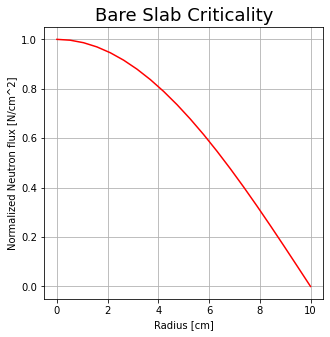

In [10]:
import pandas as pd

df = pd.read_csv('inputEigenProblem_out_x-data_0001.csv')
df2 = pd.read_csv('inputEigenProblem_out.csv')
unormal=df2["u-normalized"]
fig = plt.figure(figsize=(5,5))
plt.plot(df["x"],df["u"]/unormal[1],"r-")

u_values=df["u"]/unormal[1]
plt.grid()

plt.xlabel("Radius [cm]")
plt.ylabel("Normalized Neutron flux [N/cm^2]")
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)

plt.title("Bare Slab Criticality")
plt.show()



In [23]:
print(u_values.to_string(index=False))

1.000017e+00
9.966019e-01
9.863783e-01
9.694174e-01
9.458334e-01
9.157896e-01
8.794890e-01
8.371808e-01
7.891547e-01
7.357359e-01
6.772942e-01
6.142228e-01
5.469581e-01
4.759558e-01
4.017016e-01
3.247060e-01
2.454887e-01
1.645985e-01
8.258033e-02
7.096627e-09


#### [Two-Group Energy](#toc)<a id="twogroupenergy"></a>

In [25]:
!cat inputEigenProblem.hit


[Problem]
  type = EigenProblem
  coord_type = XYZ
[]

[Mesh]
  [1d]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = ${replace xmin}
    xmax = ${replace xmax}
    nx = 30
    elem_type = edge3
  []
[]

[Variables]
  [u]
    order = second
    family = lagrange
  
  []
  
[]

[Kernels]
  [diffusion-term]
    type = DiffusionTerm
    variable = u     # produced quantity
    diffCoeff = ${replace diff_coeff}
  []
  
  [eigenvalue-term]
    type = CoefReaction
    variable = u     # produced quantity
    extra_vector_tags='eigen'
	coefficient = -1.0
  []

  

[]

[BCs]
  [entry]
    type = NeumannBC
	
    variable = u
    boundary = left
    value = ${replace u_left}
  []
 
   [exit-u]
    type = DirichletBC
    variable = u
    boundary = right
	value= 0
  []
 

[]



[Executioner]
  type = Eigenvalue
  solve_type = PJFNK
  nl_abs_tol = 1e-8
  nl_rel_tol = 1e-8
   
   # Postprocessor value to normalize
  normalization ='u-normalized'

  
[]

[VectorPostprocessors]
  [eigenvalue

In [4]:
!rm inputEigenProblem_out_eigenvalue-data_0001*.csv
!./neutron__transport-opt -i inputEigenProblem.hit


Framework Information:
MOOSE Version:           git commit b98ea2c450 on 2021-09-23
LibMesh Version:         
PETSc Version:           3.15.1
SLEPc Version:           3.15.1
Current Time:            Mon May  2 14:32:43 2022
Executable Timestamp:    Mon May  2 14:30:45 2022

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   61
  Elems:                   30
  Num Subdomains:          1

Nonlinear System:
  Num DOFs:                61
  Num Local DOFs:          61
  Variables:               "u" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Execution Information:
  Executioner:             Eigenvalue
  Solver Mode:             Preconditioned JFNK


Postprocessor Values:
+----------------+----------------+
| time           | u-normalized   |
+----------------+----------------+
|   0.000000e+00 |   1.000000e+0

In [5]:
import numpy as np
import pandas as pd
df = pd.read_csv('inputEigenProblem_out_eigenvalue-data_0001.csv')
lam =df["eigen_values_real"]


sigma_a1=.1
sigma_f1=.1
v1=2.4355

#k=v[0]*sigma_f[0]/(lam+sigma_a[0])

k1=v1*sigma_f1/(lam+sigma_a1)
print('Multiplicity factor for group-1 = ',k1)



Multiplicity factor for group-1 =  0    1.797011
Name: eigen_values_real, dtype: float64


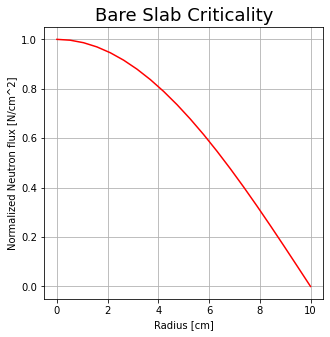

In [6]:
import pandas as pd

df = pd.read_csv('inputEigenProblem_out_x-data_0001.csv')
df2 = pd.read_csv('inputEigenProblem_out.csv')
unormal=df2["u-normalized"]
fig = plt.figure(figsize=(5,5))
plt.plot(df["x"],df["u"]/unormal[1],"r-")

u_values=df["u"]/unormal[1]
plt.grid()

plt.xlabel("Radius [cm]")
plt.ylabel("Normalized Neutron flux [N/cm^2]")
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)

plt.title("Bare Slab Criticality")
plt.show()



In [7]:
print(u_values.to_string(index=False))

1.000017e+00
9.966019e-01
9.863783e-01
9.694174e-01
9.458334e-01
9.157896e-01
8.794890e-01
8.371808e-01
7.891547e-01
7.357359e-01
6.772942e-01
6.142228e-01
5.469581e-01
4.759558e-01
4.017016e-01
3.247060e-01
2.454887e-01
1.645985e-01
8.258033e-02
7.096627e-09


#### [Two-Group Energy](#toc)<a id="twogroupenergy"></a>

In [29]:
!./neutron__transport-opt -i inputEigenProblem2g.hit


Framework Information:
MOOSE Version:           git commit b98ea2c450 on 2021-09-23
LibMesh Version:         
PETSc Version:           3.15.1
SLEPc Version:           3.15.1
Current Time:            Mon May  2 14:36:23 2022
Executable Timestamp:    Mon May  2 14:30:45 2022

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   71
  Elems:                   35
  Num Subdomains:          1

Nonlinear System:
  Num DOFs:                142
  Num Local DOFs:          142
  Variables:               { "u1" "u2" } 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Auxiliary System:
  Num DOFs:                140
  Num Local DOFs:          140
  Variables:               { "diffFlux_u1" "diffFlux_u2" } 
  Finite Element Types:    "MONOMIAL" 
  Approximation Orders:    "FIRST" 

Execution Information:
  Executioner:       

In [30]:
import numpy as np
import pandas as pd
df = pd.read_csv('inputEigenProblem2g_out_eigenvalue-data_0001.csv')
lam =df["eigen_values_real"]

k=[v[0]*chi[0]*sigma_f[0]/(lam+sigma_a[0]-sigma_12),
   v[1]*chi[1]*sigma_f[1]/(lam+sigma_a[1]+sigma_12) ] 

print('Multiplicity factor for group-1 = ',k[0])
print('Multiplicity factor for group-2 = ',k[1])

Multiplicity factor for group-1 =  0    0.914032
Name: eigen_values_real, dtype: float64
Multiplicity factor for group-2 =  0    0.381979
Name: eigen_values_real, dtype: float64


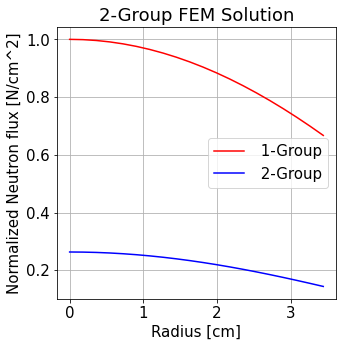

In [32]:
import pandas as pd
df = pd.read_csv('inputEigenProblem2g_out_x-data_0001.csv')
df2 = pd.read_csv('inputEigenProblem2g_out.csv')
unormal=df2["u-normalized"]
unormal2=df2["u-normalized2"]
fig = plt.figure(figsize=(5,5))

plt.plot(df["x"],df["u1"]/unormal[1],"r-",label=" 1-Group")
plt.plot(df["x"],df["u2"]/unormal[1],"b-",label=" 2-Group")
#plt.yscale("log")
#plt.xlim(0,100)
plt.grid()
plt.legend()
plt.xlabel("Radius [cm]")
plt.ylabel("Normalized Neutron flux [N/cm^2]")
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.title("2-Group FEM Solution")

plt.show()

## 2 Domain Problem

In [18]:
x_a = 0.0
x_interface = 3.44
x_b = 10.0

fdp_full = True

diff_coeff_u1_c = 1.84
diff_coeff_u2_c = 1.03

diff_coeff_u1_m = 1.64
diff_coeff_u2_m = 0.597

sigma_s12_c = 0.0337
sigma_s12_m = 0.0681

fiss_u1_c = 0.174
fiss_u2_c = 0.0560

fiss_u2_to_u1 = 0.141
fiss_u1_to_u2 = 0.0673

sigma_abs_u1_c = 0.0745
sigma_abs_u2_c = 0.0784

sigma_abs_u1_m = 0.00534
sigma_abs_u2_m = 1.13e-5

order = variable_order = 'second'
flux_order = 'first'

diffFlux_family = 'monomial_vec'
diffFlux_r_family = 'monomial'

#robin_u_ref = 0.0
#robin_transfer_coeff = 10.0e+10

n_felem_core = 30
n_felem_reflector = 30

u1_initial = 100000
u2_initial = 100000

interfacial_transfer_coeff = 1000000000000000000.0
interfacial_adsorption_coeff = 0

u1_bc_left_neumann = 0
u2_bc_left_neumann = 0

u1_bc_right_robin_transfer_coeff = 10.0e+10
u2_bc_right_robin_transfer_coeff = 10.0e+10

n_plot_pts_core = 2*n_felem_core + 1
n_plot_pts_reflector = 2*n_felem_reflector + 1

flux_ref = 0.0   #u_ref for robin boundary condition

inputFileName = "input_2Domain.hit"

In [19]:
def write_input_file_1d_coupled(pjfnk=False,filename='input.hit'):
    import pyhit
    import moosetree
    root = pyhit.load('')

    prblm = root.insert(-1,'Problem')
    prblm['type'] = 'FEProblem'
    prblm['coord_type'] = 'RSPHERICAL'

    mesh = root.insert(-1,'Mesh')
    
    omega1 = mesh.insert(-1,'omega1')
    omega1['type'] = 'GeneratedMeshGenerator'
    omega1['dim'] = 1
    omega1['xmin'] = x_a
    omega1['xmax'] = x_interface
    omega1['nx'] = n_felem_core
    omega1['boundary_name_prefix'] = 'omega_1'
    if order == 'second':
        omega1['elem_type'] = 'edge3'
    
    omega2 = mesh.insert(-1,'omega2')
    omega2['type'] = 'GeneratedMeshGenerator'
    omega2['dim'] = 1
    omega2['xmin'] = x_interface
    omega2['xmax'] = x_b
    omega2['nx'] = n_felem_reflector
    omega2['boundary_name_prefix'] = 'omega_2'
    if order == 'second':
        omega2['elem_type'] = 'edge3'

    omega = mesh.insert(-1,'omega')
    omega['type'] = 'StitchedMeshGenerator'
    omega['inputs'] = "'omega1 omega2'"
    omega['stitch_boundaries_pairs'] = "'omega_1_right omega_2_left'"
    omega['clear_stitched_boundary_ids'] = 'true'
    
    mod1 = mesh.insert(-1,'mod1')
    mod1['type'] = 'SubdomainBoundingBoxGenerator'
    mod1['input'] = 'omega'
    mod1['block_id'] = 1
    mod1['block_name'] = 'omega_1'
    mod1['bottom_left'] = str(x_a)+' 0 0'
    mod1['top_right'] = str(x_interface)+' 1 0'
    
    mod2 = mesh.insert(-1,'mod2')
    mod2['type'] = 'SubdomainBoundingBoxGenerator'
    mod2['input'] = 'mod1'
    mod2['block_id'] = 2
    mod2['block_name'] = 'omega_2'
    mod2['bottom_left'] = str(x_interface)+' 0 0'
    mod2['top_right'] = str(x_b)+' 1 0'
    
    mod3 = mesh.insert(-1,'mod3')
    mod3['type'] = 'SideSetsBetweenSubdomainsGenerator'
    mod3['input'] = 'mod2'
    mod3['primary_block'] = 'omega_1'
    mod3['paired_block'] = 'omega_2' 
    mod3['new_boundary'] = 'interface_12'
    
    mod4 = mesh.insert(-1,'mod4')
    mod4['type'] = 'SideSetsAroundSubdomainGenerator'
    mod4['input'] = 'mod3'
    mod4['block'] = 'omega_1'
    mod4['normal'] = '-1 0 0'
    mod4['new_boundary'] = 'omega_1_left'
    
    mod5 = mesh.insert(-1,'mod5')
    mod5['type'] = 'SideSetsAroundSubdomainGenerator'
    mod5['input'] = 'mod4'
    mod5['block'] = 'omega_2'
    mod5['normal'] = '1 0 0'
    mod5['new_boundary'] = 'omega_2_right'
    
    vars = root.insert(-1,'Variables')
    
    u1_c = vars.insert(-1,'u1_c')
    u1_c['block'] = 'omega_1'
    u1_c['order'] = order
    u1_c['family'] = 'lagrange'
    u1_c['initial_condition'] = u1_initial
    
    u2_c = vars.insert(-1,'u2_c')
    u2_c['block'] = 'omega_1'
    u2_c['order'] = order
    u2_c['family'] = 'lagrange'
    u2_c['initial_condition'] = u2_initial
    
    u1_m = vars.insert(-1,'u1_m')
    u1_m['block'] = 'omega_2'
    u1_m['order'] = order
    u1_m['family'] = 'lagrange'
    u1_m['initial_condition'] = u1_initial
    
    u2_m = vars.insert(-1,'u2_m')
    u2_m['block'] = 'omega_2'
    u2_m['order'] = order
    u2_m['family'] = 'lagrange'
    u2_m['initial_condition'] = u2_initial
    
    
    aux_vars = root.insert(-1,'AuxVariables')
    
    diffFlux_u1_c = aux_vars.insert(-1,'diffFlux_u1_c')
    diffFlux_u1_c['block'] = 'omega_1'
    diffFlux_u1_c['order'] = flux_order
    diffFlux_u1_c['family'] = diffFlux_family
    
    diffFlux_u2_c = aux_vars.insert(-1,'diffFlux_u2_c')
    diffFlux_u2_c['block'] = 'omega_1'
    diffFlux_u2_c['order'] = flux_order
    diffFlux_u2_c['family'] = diffFlux_family
    
    diffFlux_u1_m = aux_vars.insert(-1,'diffFlux_u1_m')
    diffFlux_u1_m['block'] = 'omega_2'
    diffFlux_u1_m['order'] = flux_order
    diffFlux_u1_m['family'] = diffFlux_family
    
    diffFlux_u2_m = aux_vars.insert(-1,'diffFlux_u2_m')
    diffFlux_u2_m['block'] = 'omega_2'
    diffFlux_u2_m['order'] = flux_order
    diffFlux_u2_m['family'] = diffFlux_family
    
    
    diffFlux_u1_c_r = aux_vars.insert(-1,'diffFlux_u1_c_r')
    diffFlux_u1_c_r['block'] = 'omega_1'
    diffFlux_u1_c_r['order'] = flux_order
    diffFlux_u1_c_r['family'] = diffFlux_r_family

    diffFlux_u2_c_r = aux_vars.insert(-1,'diffFlux_u2_c_r')
    diffFlux_u2_c_r['block'] = 'omega_1'
    diffFlux_u2_c_r['order'] = flux_order
    diffFlux_u2_c_r['family'] = diffFlux_r_family

    diffFlux_u1_m_r = aux_vars.insert(-1,'diffFlux_u1_m_r')
    diffFlux_u1_m_r['block'] = 'omega_2'
    diffFlux_u1_m_r['order'] = flux_order
    diffFlux_u1_m_r['family'] = diffFlux_r_family

    diffFlux_u2_m_r = aux_vars.insert(-1,'diffFlux_u2_m_r')
    diffFlux_u2_m_r['block'] = 'omega_2'
    diffFlux_u2_m_r['order'] = flux_order
    diffFlux_u2_m_r['family'] = diffFlux_r_family

    kernels = root.insert(-1,'Kernels')
    
    diffusion_term_u1_c = kernels.insert(-1,'diffusion_term_u1_c')
    diffusion_term_u1_c['type'] = 'DiffusionTerm'
    diffusion_term_u1_c['block'] = 'omega_1'
    diffusion_term_u1_c['variable'] = 'u1_c'
    diffusion_term_u1_c['diffCoeff'] = diff_coeff_u1_c
    
    diffusion_term_u2_c = kernels.insert(-1,'diffusion_term_u2_c')
    diffusion_term_u2_c['type'] = 'DiffusionTerm'
    diffusion_term_u2_c['block'] = 'omega_1'
    diffusion_term_u2_c['variable'] = 'u2_c'
    diffusion_term_u2_c['diffCoeff'] = diff_coeff_u2_c
    
    diffusion_term_u1_m = kernels.insert(-1,'diffusion_term_u1_m')
    diffusion_term_u1_m['type'] = 'DiffusionTerm'
    diffusion_term_u1_m['block'] = 'omega_2'
    diffusion_term_u1_m['variable'] = 'u1_m'
    diffusion_term_u1_m['diffCoeff'] = diff_coeff_u1_m
    
    diffusion_term_u2_m = kernels.insert(-1,'diffusion_term_u2_m')
    diffusion_term_u2_m['type'] = 'DiffusionTerm'
    diffusion_term_u2_m['block'] = 'omega_2'
    diffusion_term_u2_m['variable'] = 'u2_m'
    diffusion_term_u2_m['diffCoeff'] = diff_coeff_u2_m
    
    
    group_scattering_u1_c = kernels.insert(-1,'group_scattering_u1_c')
    group_scattering_u1_c['type'] = 'SourceTermG1'
    group_scattering_u1_c['block'] = 'omega_1'
    group_scattering_u1_c['variable'] = 'u1_c'
    group_scattering_u1_c['sigma_sa'] = sigma_s12_c
    
    group_scattering_u2_c = kernels.insert(-1,'group_scattering_u2_c')
    group_scattering_u2_c['type'] = 'SourceTermG2'
    group_scattering_u2_c['block'] = 'omega_1'
    group_scattering_u2_c['variable'] = 'u2_c'
    group_scattering_u2_c['coupledGroupA'] = 'u1_c'
    group_scattering_u2_c['coupledGroupB'] = 'u2_c'
    group_scattering_u2_c['sigma_sa'] = sigma_s12_c
    
    group_scattering_u1_m = kernels.insert(-1,'group_scattering_u1_m')
    group_scattering_u1_m['type'] = 'SourceTermG1'
    group_scattering_u1_m['block'] = 'omega_2'
    group_scattering_u1_m['variable'] = 'u1_m'
    group_scattering_u1_m['sigma_sa'] = sigma_s12_m
    
    group_scattering_u2_m = kernels.insert(-1,'group_scattering_u2_m')
    group_scattering_u2_m['type'] = 'SourceTermG2'
    group_scattering_u2_m['block'] = 'omega_2'
    group_scattering_u2_m['variable'] = 'u2_m'
    group_scattering_u2_m['coupledGroupA'] = 'u1_m'
    group_scattering_u2_m['coupledGroupB'] = 'u2_m'
    group_scattering_u2_m['sigma_sa'] = sigma_s12_m
    
    fission_source_u1_c = kernels.insert(-1,'fission_source_u1_c')
    fission_source_u1_c['type'] = 'FissionSource'
    fission_source_u1_c['block'] = 'omega_1'
    fission_source_u1_c['variable'] = 'u1_c'
    fission_source_u1_c['sourceS'] = fiss_u1_c
    
    fission_source_u2_c = kernels.insert(-1,'fission_source_u2_c')
    fission_source_u2_c['type'] = 'FissionSource'
    fission_source_u2_c['block'] = 'omega_1'
    fission_source_u2_c['variable'] = 'u2_c'
    fission_source_u1_c['sourceS'] = fiss_u2_c
    
    fission_source_u1_to_u2_c = kernels.insert(-1,'fission_source_u1_to_u2_c')
    fission_source_u1_to_u2_c['type'] = 'SourceTermG2'
    fission_source_u1_to_u2_c['block'] = 'omega_1'
    fission_source_u1_to_u2_c['variable'] = 'u2_c'
    fission_source_u1_to_u2_c['coupledGroupA'] = 'u1_c'
    fission_source_u1_to_u2_c['coupledGroupB'] = 'u2_c'
    fission_source_u1_to_u2_c['sigma_sa'] = fiss_u1_to_u2
    
    fission_source_u2_to_u1_c = kernels.insert(-1,'fission_source_u2_to_u1_c')
    fission_source_u2_to_u1_c['type'] = 'SourceTermG2'
    fission_source_u2_to_u1_c['block'] = 'omega_1'
    fission_source_u2_to_u1_c['variable'] = 'u1_c'
    fission_source_u2_to_u1_c['coupledGroupA'] = 'u2_c'
    fission_source_u2_to_u1_c['coupledGroupB'] = 'u1_c'
    fission_source_u2_to_u1_c['sigma_sa'] = fiss_u2_to_u1
    
    abs_u1_c = kernels.insert(-1,'abs_u1_c')
    abs_u1_c['type'] = 'SourceTermG1'
    abs_u1_c['block'] = 'omega_1'
    abs_u1_c['variable'] = 'u1_c'
    abs_u1_c['sigma_sa'] = sigma_abs_u1_c
    
    abs_u2_c = kernels.insert(-1,'abs_u2_c')
    abs_u2_c['type'] = 'SourceTermG1'
    abs_u2_c['block'] = 'omega_1'
    abs_u2_c['variable'] = 'u2_c'
    abs_u2_c['sigma_sa'] = sigma_abs_u2_c
    
    abs_u1_m = kernels.insert(-1,'abs_u1_m')
    abs_u1_m['type'] = 'SourceTermG1'
    abs_u1_m['block'] = 'omega_2'
    abs_u1_m['variable'] = 'u1_m'
    abs_u1_m['sigma_sa'] = sigma_abs_u1_m
    
    abs_u2_m = kernels.insert(-1,'abs_u2_m')
    abs_u2_m['type'] = 'SourceTermG1'
    abs_u2_m['block'] = 'omega_2'
    abs_u2_m['variable'] = 'u2_m'
    abs_u2_m['sigma_sa'] = sigma_abs_u2_m
    
    interf_kernels = root.insert(-1,'InterfaceKernels')
    
    scalar_flux_continuity_u1 = interf_kernels.insert(-1,'scalar_flux_continuity_u1')
    scalar_flux_continuity_u1['type'] = 'InterfaceNormalFluxContinuity'
    scalar_flux_continuity_u1['variable'] = 'u1_c'
    scalar_flux_continuity_u1['neighbor_var'] = 'u1_m'
    scalar_flux_continuity_u1['boundary'] = 'interface_12'
    scalar_flux_continuity_u1['thermCond'] = diff_coeff_u1_c
    scalar_flux_continuity_u1['thermCondNeighbor'] = diff_coeff_u1_m
    
    scalar_flux_jump_u1 = interf_kernels.insert(-1,'scalar_flux_jump_u1')
    scalar_flux_jump_u1['type'] = 'InterfacePartition'
    scalar_flux_jump_u1['variable'] = 'u1_c'
    scalar_flux_jump_u1['neighbor_var'] = 'u1_m'
    scalar_flux_jump_u1['boundary'] = 'interface_12'
    scalar_flux_jump_u1['kCoeff'] = 1
    
    scalar_flux_continuity_u2 = interf_kernels.insert(-1,'scalar_flux_continuity_u2')
    scalar_flux_continuity_u2['type'] = 'InterfaceNormalFluxContinuity'
    scalar_flux_continuity_u2['variable'] = 'u2_c'
    scalar_flux_continuity_u2['neighbor_var'] = 'u2_m'
    scalar_flux_continuity_u2['boundary'] = 'interface_12'
    scalar_flux_continuity_u2['thermCond'] = diff_coeff_u2_c
    scalar_flux_continuity_u2['thermCondNeighbor'] = diff_coeff_u2_m
    
    scalar_flux_jump_u2 = interf_kernels.insert(-1,'scalar_flux_jump_u2')
    scalar_flux_jump_u2['type'] = 'InterfacePartition'
    scalar_flux_jump_u2['variable'] = 'u2_c'
    scalar_flux_jump_u2['neighbor_var'] = 'u2_m'
    scalar_flux_jump_u2['boundary'] = 'interface_12'
    scalar_flux_jump_u2['kCoeff'] = 1
    
    """scalar_flux_continuity_u1 = interf_kernels.insert(-1,'scalar_flux_continuity_u1')
    scalar_flux_continuity_u1['type'] = 'InterfaceNormalFluxContinuity'
    scalar_flux_continuity_u1['variable'] = 'u1_c'
    scalar_flux_continuity_u1['neighbor_var'] = 'u1_m'
    scalar_flux_continuity_u1['boundary'] = 'interface_12'
    scalar_flux_continuity_u1['thermCond'] = diff_coeff_u1_c
    scalar_flux_continuity_u1['thermCondNeighbor'] = diff_coeff_u1_m
    
    scalar_flux_jump_u1 = interf_kernels.insert(-1,'scalar_flux_jump_u1')
    scalar_flux_jump_u1['type'] = 'InterfaceJump'
    scalar_flux_jump_u1['variable'] = 'u1_c'
    scalar_flux_jump_u1['neighbor_var'] = 'u1_m'
    scalar_flux_jump_u1['boundary'] = 'interface_12'
    scalar_flux_jump_u1['transferCoeff'] = interfacial_transfer_coeff
    scalar_flux_jump_u1['adsorptionCoeff'] = interfacial_adsorption_coeff 
    scalar_flux_jump_u1['thermCondCoeff'] = diff_coeff_u1_c
    
    scalar_flux_continuity_u2 = interf_kernels.insert(-1,'scalar_flux_continuity_u2')
    scalar_flux_continuity_u2['type'] = 'InterfaceNormalFluxContinuity'
    scalar_flux_continuity_u2['variable'] = 'u2_c'
    scalar_flux_continuity_u2['neighbor_var'] = 'u2_m'
    scalar_flux_continuity_u2['boundary'] = 'interface_12'
    scalar_flux_continuity_u2['thermCond'] = diff_coeff_u2_c
    scalar_flux_continuity_u2['thermCondNeighbor'] = diff_coeff_u2_m
    
    scalar_flux_jump_u2 = interf_kernels.insert(-1,'scalar_flux_jump_u2')
    scalar_flux_jump_u2['type'] = 'InterfaceJump'
    scalar_flux_jump_u2['variable'] = 'u2_c'
    scalar_flux_jump_u2['neighbor_var'] = 'u2_m'
    scalar_flux_jump_u2['boundary'] = 'interface_12'
    scalar_flux_jump_u2['transferCoeff'] = interfacial_transfer_coeff
    scalar_flux_jump_u2['adsorptionCoeff'] = interfacial_adsorption_coeff
    scalar_flux_jump_u2['thermCondCoeff'] = diff_coeff_u2_c"""
    
    aux_kernels = root.insert(-1,'AuxKernels')
    
    diffusion_flux_u1_c = aux_kernels.insert(-1,'diffusion_flux_u1_c')
    diffusion_flux_u1_c['type'] = 'HeatFlux'
    diffusion_flux_u1_c['block'] = 'omega_1'
    diffusion_flux_u1_c['field'] = 'u1_c'
    diffusion_flux_u1_c['thCondCoeff'] = diff_coeff_u1_c
    diffusion_flux_u1_c['component'] = "x"
    diffusion_flux_u1_c['variable'] = 'diffFlux_u1_c'
    diffusion_flux_u1_c['execute_on'] = 'timestep_end'
    
    diffusion_flux_u2_c = aux_kernels.insert(-1,'diffusion_flux_u2_c')
    diffusion_flux_u2_c['type'] = 'HeatFlux'
    diffusion_flux_u2_c['block'] = 'omega_1'
    diffusion_flux_u2_c['field'] = 'u2_c'
    diffusion_flux_u2_c['thCondCoeff'] = diff_coeff_u2_c
    diffusion_flux_u2_c['component'] = "x"
    diffusion_flux_u2_c['variable'] = 'diffFlux_u2_c'
    diffusion_flux_u2_c['execute_on'] = 'timestep_end'
    
    diffusion_flux_u1_m = aux_kernels.insert(-1,'diffusion_flux_u1_m')
    diffusion_flux_u1_m['type'] = 'HeatFlux'
    diffusion_flux_u1_m['block'] = 'omega_2'
    diffusion_flux_u1_m['field'] = 'u1_m'
    diffusion_flux_u1_m['thCondCoeff'] = diff_coeff_u1_m
    diffusion_flux_u1_m['component'] = "x"
    diffusion_flux_u1_m['variable'] = 'diffFlux_u1_m'
    diffusion_flux_u1_m['execute_on'] = 'timestep_end'
    
    diffusion_flux_u2_m = aux_kernels.insert(-1,'diffusion_flux_u2_m')
    diffusion_flux_u2_m['type'] = 'HeatFlux'
    diffusion_flux_u2_m['block'] = 'omega_2'
    diffusion_flux_u2_m['field'] = 'u2_m'
    diffusion_flux_u2_m['thCondCoeff'] = diff_coeff_u2_m
    diffusion_flux_u2_m['component'] = "x"
    diffusion_flux_u2_m['variable'] = 'diffFlux_u2_m'
    diffusion_flux_u2_m['execute_on'] = 'timestep_end'
    
    """diffusion_flux_u1_c = aux_kernels.insert(-1,'diffusion_flux_u1_c')
    diffusion_flux_u1_c['type'] = 'DiffusionFluxComponent'
    diffusion_flux_u1_c['block'] = 'omega_1'
    diffusion_flux_u1_c['field'] = 'u1_c'
    diffusion_flux_u1_c['diffCoeff'] = diff_coeff_u1_c
    diffusion_flux_u1_c['component'] = "x"
    diffusion_flux_u1_c['variable'] = 'diffFlux_u1_c'
    diffusion_flux_u1_c['execute_on'] = 'timestep_end'
    
    diffusion_flux_u2_c = aux_kernels.insert(-1,'diffusion_flux_u2_c')
    diffusion_flux_u2_c['type'] = 'DiffusionFluxComponent'
    diffusion_flux_u2_c['block'] = 'omega_1'
    diffusion_flux_u2_c['field'] = 'u2_c'
    diffusion_flux_u2_c['diffCoeff'] = diff_coeff_u2_c
    diffusion_flux_u2_c['component'] = "x"
    diffusion_flux_u2_c['variable'] = 'diffFlux_u2_c'
    diffusion_flux_u2_c['execute_on'] = 'timestep_end'
    
    diffusion_flux_u1_m = aux_kernels.insert(-1,'diffusion_flux_u1_m')
    diffusion_flux_u1_m['type'] = 'DiffusionFluxComponent'
    diffusion_flux_u1_m['block'] = 'omega_2'
    diffusion_flux_u1_m['field'] = 'u1_m'
    diffusion_flux_u1_m['diffCoeff'] = diff_coeff_u1_m
    diffusion_flux_u1_m['component'] = "x"
    diffusion_flux_u1_m['variable'] = 'diffFlux_u1_m'
    diffusion_flux_u1_m['execute_on'] = 'timestep_end'
    
    diffusion_flux_u2_m = aux_kernels.insert(-1,'diffusion_flux_u2_m')
    diffusion_flux_u2_m['type'] = 'DiffusionFluxComponent'
    diffusion_flux_u2_m['block'] = 'omega_2'
    diffusion_flux_u2_m['field'] = 'u2_m'
    diffusion_flux_u2_m['diffCoeff'] = diff_coeff_u2_m
    diffusion_flux_u2_m['component'] = "x"
    diffusion_flux_u2_m['variable'] = 'diffFlux_u2_m'
    diffusion_flux_u2_m['execute_on'] = 'timestep_end'"""
    
    
    diffusion_flux_u1_c_r = aux_kernels.insert(-1,'diffusion_flux_u1_c_r')
    diffusion_flux_u1_c_r['type'] = 'VectorVariableComponentAux'
    diffusion_flux_u1_c_r['block'] = 'omega_1'
    diffusion_flux_u1_c_r['vector_variable'] = 'diffFlux_u1_c'
    diffusion_flux_u1_c_r['component'] = "x"
    diffusion_flux_u1_c_r['variable'] = 'diffFlux_u1_c_r'
    diffusion_flux_u1_c_r['execute_on'] = 'timestep_end'

    diffusion_flux_u2_c_r = aux_kernels.insert(-1,'diffusion_flux_u2_c_r')
    diffusion_flux_u2_c_r['type'] = 'VectorVariableComponentAux'
    diffusion_flux_u2_c_r['block'] = 'omega_1'
    diffusion_flux_u2_c_r['vector_variable'] = 'diffFlux_u2_c'
    diffusion_flux_u2_c_r['component'] = "x"
    diffusion_flux_u2_c_r['variable'] = 'diffFlux_u2_c_r'
    diffusion_flux_u2_c_r['execute_on'] = 'timestep_end'

    diffusion_flux_u1_m_r = aux_kernels.insert(-1,'diffusion_flux_u1_m_r')
    diffusion_flux_u1_m_r['type'] = 'VectorVariableComponentAux'
    diffusion_flux_u1_m_r['block'] = 'omega_2'
    diffusion_flux_u1_m_r['vector_variable'] = 'diffFlux_u1_m'
    diffusion_flux_u1_m_r['component'] = "x"
    diffusion_flux_u1_m_r['variable'] = 'diffFlux_u1_m_r'
    diffusion_flux_u1_m_r['execute_on'] = 'timestep_end'
 
    diffusion_flux_u2_m_r = aux_kernels.insert(-1,'diffusion_flux_u2_m_r')
    diffusion_flux_u2_m_r['type'] = 'VectorVariableComponentAux'
    diffusion_flux_u2_m_r['block'] = 'omega_2'
    diffusion_flux_u2_m_r['vector_variable'] = 'diffFlux_u2_m'
    diffusion_flux_u2_m_r['component'] = "x"
    diffusion_flux_u2_m_r['variable'] = 'diffFlux_u2_m_r'
    diffusion_flux_u2_m_r['execute_on'] = 'timestep_end'
    
    
    bcs = root.insert(-1,'BCs')
    
    entry_u1 = bcs.insert(-1,'entry_u1')
    entry_u1['type'] = 'NeumannBC'
    entry_u1['variable'] = 'u1_c'
    entry_u1['boundary'] = 'omega_1_left'
    entry_u1['value'] = u1_bc_left_neumann 
    
    exit_u1 = bcs.insert(-1,'exit_u1')
    exit_u1['type'] = 'VacuumBC'
    exit_u1['variable'] = 'u1_m'
    exit_u1['boundary'] = 'omega_2_right'

    
    """exit_u1 = bcs.insert(-1,'exit_u1')
    exit_u1['type'] = 'NormalHeatFluxBC'
    exit_u1['variable'] = 'u1_m'
    exit_u1['boundary'] = 'omega_2_right'
    exit_u1['refTempFunc'] = 'refFluxFunc'
    exit_u1['transferCoeff'] = 'u1_bc_right_robin_transfer_coeff'"""
    
    entry_u2 = bcs.insert(-1,'entry_u2')
    entry_u2['type'] = 'NeumannBC'
    entry_u2['variable'] = 'u2_c'
    entry_u2['boundary'] = 'omega_1_left'
    entry_u2['value'] = u2_bc_left_neumann 
    
    exit_u2 = bcs.insert(-1,'exit_u2')
    exit_u2['type'] = 'VacuumBC'
    exit_u2['variable'] = 'u2_m'
    exit_u2['boundary'] = 'omega_2_right'
    
    """exit_u2 = bcs.insert(-1,'exit_u2')
    exit_u2['type'] = 'NormalHeatFluxBC'
    exit_u2['variable'] = 'u2_m'
    exit_u2['boundary'] = 'omega_2_right'
    exit_u2['refTempFunc'] = 'refFluxFunc'
    exit_u2['transferCoeff'] = 'u2_bc_right_robin_transfer_coeff'"""
    
    functions = root.insert(-1,'Functions')
    
    ref_flux_func = functions.insert(-1, 'refFluxFunc')
    ref_flux_func['type'] = 'ParsedFunction'
    ref_flux_func['value'] = 'flux_ref'
    ref_flux_func['vars'] = 'flux_ref'
    ref_flux_func['vals'] = str(flux_ref)
    
    if pjfnk:
        exe = root.insert(-1,'Executioner')
        exe['type'] = 'Steady'
        exe['solve_type']  = 'PJFNK'
        exe['petsc_options_iname']  = '-pc_type -pc_hypre_type'
        exe['petsc_options_value']  = 'hypre boomeramg'
        exe['l_max_its']  = 20
        exe['l_tol']  = 1e-5
        exe['nl_max_its']  = 15
        exe['nl_rel_tol']  = 1e-8
        exe['nl_abs_tol']  = 1e-8
    elif fdp_full:
        pre = root.insert(-1, 'Preconditioning')
        pre['active'] = 'fdp-newt-full'
        
        fdp = pre.insert(-1, 'fdp-newt-full')
        fdp['type'] = 'FDP'
        fdp['full'] = 'true'
        fdp['solve_type'] = 'NEWTON'
        fdp['petsc_options_iname'] = ""'-pc_type -mat_fd_coloring_err -mat_fd_type'""
        fdp['petsc_options_value'] = ""'lu  1e-8          ds'""
        
        exe = root.insert(-1,'Executioner')
        exe['type'] = 'Steady'

    vp = root.insert(-1,'VectorPostprocessors')
    
    omega_1 = vp.insert(-1,'omega_1')
    omega_1['type'] = 'LineValueSampler'
    omega_1['execute_on'] = 'timestep_end final'
    omega_1['variable'] = 'u1_c u2_c diffFlux_u1_c_r diffFlux_u2_c_r'  
    omega_1['start_point'] = str(x_a)+' 0 0'
    omega_1['end_point'] = str(x_interface*0.999)+' 0 0'
    omega_1['num_points'] = n_plot_pts_core
    omega_1['sort_by'] = 'id'
    
    omega_2 = vp.insert(-1,'omega_2')
    omega_2['type'] = 'LineValueSampler'
    omega_2['execute_on'] = 'timestep_end final'
    omega_2['variable'] = 'u1_m u2_m diffFlux_u1_m_r diffFlux_u2_m_r'   
    omega_2['start_point'] = str(x_interface*1.001)+' 0 0'
    omega_2['end_point'] = str(x_b)+' 0 0'
    omega_2['num_points'] = n_plot_pts_reflector
    omega_2['sort_by'] = 'id'  

    out = root.insert(-1,'Outputs')
    out['console'] = 'true'
    csv = out.insert(-1,'csv')
    csv['type'] = 'CSV'
    csv['file_base'] = 'output'
    csv['execute_on'] = 'final'
    
    debug = root.insert(-1,'Debug')
    debug['show_var_residual_norms'] = 'true'

    pyhit.write(filename, root)

In [20]:
write_input_file_1d_coupled(pjfnk=True,filename=inputFileName)
!cat input_2Domain.hit

[Problem]
  type = FEProblem
  coord_type = RSPHERICAL
[]
[Mesh]
  [omega1]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = 0.0
    xmax = 3.44
    nx = 30
    boundary_name_prefix = omega_1
    elem_type = edge3
  []
  [omega2]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = 3.44
    xmax = 10.0
    nx = 30
    boundary_name_prefix = omega_2
    elem_type = edge3
  []
  [omega]
    type = StitchedMeshGenerator
    inputs = 'omega1 omega2'
    stitch_boundaries_pairs = 'omega_1_right omega_2_left'
    clear_stitched_boundary_ids = true
  []
  [mod1]
    type = SubdomainBoundingBoxGenerator
    input = omega
    block_id = 1
    block_name = omega_1
    bottom_left = '0.0 0 0'
    top_right = '3.44 1 0'
  []
  [mod2]
    type = SubdomainBoundingBoxGenerator
    input = mod1
    block_id = 2
    block_name = omega_2
    bottom_left = '3.44 0 0'
    top_right = '10.0 1 0'
  []
  [mod3]
    type = SideSetsBetweenSubdomainsGenerator
    input = mod2
    primary_block = ome

In [21]:
!./neutron__transport-opt -i input_2Domain.hit


In ReplicatedMesh::stitch_meshes:
This mesh has 1 nodes on boundary 1.
Other mesh has 1 nodes on boundary 0.
Minimum edge length on both surfaces is 0.114667.
In ReplicatedMesh::stitch_meshes:
Found 1 matching nodes.

Framework Information:
MOOSE Version:           git commit b98ea2c450 on 2021-09-23
LibMesh Version:         
PETSc Version:           3.15.1
SLEPc Version:           3.15.1
Current Time:            Mon May  2 14:34:52 2022
Executable Timestamp:    Mon May  2 14:30:45 2022

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   121
  Elems:                   60
  Num Subdomains:          2

Nonlinear System:
  Num DOFs:                244
  Num Local DOFs:          244
  Variables:               { "u1_c" "u2_c" } { "u1_m" "u2_m" } 
  Finite Element Types:    "LAGRANGE" "LAGRANGE" 
  Approximation Orders:    "SECOND" "SECOND" 


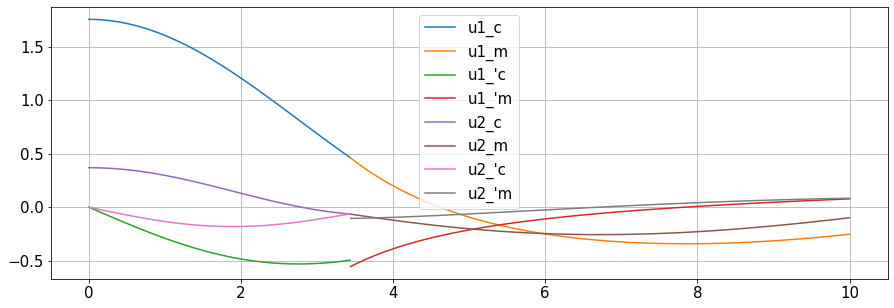

<class 'pandas.core.series.Series'>


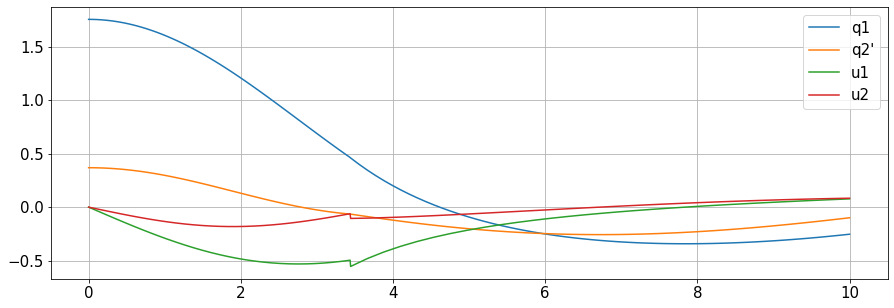

"plot_solution(df1=df1, df2=df2, title='Coupled Temperature Profile',\n              u1_legend=r'$T_p$ Lagrange Quadratic',\n              u1_flux_legend=r'$q_{p,x}$ Monomial Linear',\n              u2_legend=r'$T_c$ Lagrange Quadratic',\n              u2_flux_legend=r'$q_{c,x}$ Monomial Linear',\n              x_scale=1,\n              xlabel='x [m]', y1label=r'$T$ [C]', \n              y2_scale=1, y2label=r'$q_h$ [kW/m^2]',\n              save_name=save_name)"

In [22]:
'''Show FEM Solution'''

import pandas as pd
df1 = pd.read_csv('output_omega_1_0002.csv')
df2 = pd.read_csv('output_omega_2_0002.csv')
df_list = [df1,df2]
save_name = "2Domain.png"

#display(df1)
#display(df2)

x_list = [df1["x"],df2["x"]]
y_list = [[df1["diffFlux_u1_c_r"],df1["diffFlux_u2_c_r"],df1["u1_c"],df1["u2_c"]],
          [df2["diffFlux_u1_m_r"],df2["diffFlux_u2_m_r"],df2["u1_m"],df2["u2_m"]]]
labels = ["u1'","u2'","u1","u2"]
domain = ["core","reflector"]


plt.figure(figsize=(15,5))
for i in range(2):
    for j,domain in enumerate(["c","m"]):
        field = "u"+str(i+1)+"_"
        plt.plot(df_list[j]["x"],df_list[j][field+domain],label=field+domain)
        
    for j,domain in enumerate(["c","m"]):
        field = "u"+str(i+1)+"_"
        plt.plot(df_list[j]["x"],df_list[j]["diffFlux_u"+str(i+1)+"_"+domain+"_r"],label=field+"'"+domain)
        
plt.legend()
plt.grid()
plt.show()


x_total = pd.concat([df1["x"], df2["x"]])
u1 = pd.concat([df1["u1_c"] ,df2["u1_m"]])
u2 = pd.concat([df1["u2_c"] , df2["u2_m"]])
u1_prime = pd.concat([df1["diffFlux_u1_c_r"] , df2["diffFlux_u1_m_r"]])
u2_prime = pd.concat([df1["diffFlux_u2_c_r"] , df2["diffFlux_u2_m_r"]])

print(type(df1["u1_c"]))
data_list = [u1,u2,u1_prime,u2_prime]
labels = ["q1","q2'","u1","u2"]

plt.figure(figsize=(15,5))
for i,data in enumerate(data_list):
    plt.plot(x_total,data,label=labels[i])

plt.legend()
plt.grid()
plt.show()

"""plt.figure(figsize=(15,5))
for i,x in enumerate(x_list):
    for j,y in enumerate(y_list[i]):
        
        plt.plot(x,y,label=labels[j]+"_"+domain[i])
plt.legend()
plt.grid()
plt.show()"""
"""plot_solution(df1=df1, df2=df2, title='Coupled Temperature Profile',
              u1_legend=r'$T_p$ Lagrange Quadratic',
              u1_flux_legend=r'$q_{p,x}$ Monomial Linear',
              u2_legend=r'$T_c$ Lagrange Quadratic',
              u2_flux_legend=r'$q_{c,x}$ Monomial Linear',
              x_scale=1,
              xlabel='x [m]', y1label=r'$T$ [C]', 
              y2_scale=1, y2label=r'$q_h$ [kW/m^2]',
              save_name=save_name)"""

## 1 Domain Albedo Reflective Boundary

In [24]:
!./neutron__transport-opt -i inputEigenProblem2g_reflector.hit


Framework Information:
MOOSE Version:           git commit b98ea2c450 on 2021-09-23
LibMesh Version:         
PETSc Version:           3.15.1
SLEPc Version:           3.15.1
Current Time:            Mon May  2 14:35:01 2022
Executable Timestamp:    Mon May  2 14:30:45 2022

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   91
  Elems:                   45
  Num Subdomains:          1

Nonlinear System:
  Num DOFs:                182
  Num Local DOFs:          182
  Variables:               { "u1" "u2" } 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Auxiliary System:
  Num DOFs:                180
  Num Local DOFs:          180
  Variables:               { "diffFlux_u1" "diffFlux_u2" } 
  Finite Element Types:    "MONOMIAL" 
  Approximation Orders:    "FIRST" 

Execution Information:
  Executioner:       

In [25]:
import numpy as np
import pandas as pd
df = pd.read_csv('inputEigenProblem2g_reflector_out_eigenvalue-data_0001.csv')
lam =df["eigen_values_real"]

k=[v[0]*chi[0]*sigma_f[0]/(lam+sigma_a[0]-sigma_12),
   v[1]*chi[1]*sigma_f[1]/(lam+sigma_a[1]+sigma_12) ] 

print('Multiplicity factor for group-1 = ',k[0])
print('Multiplicity factor for group-2 = ',k[1])

Multiplicity factor for group-1 =  0    3.47237
Name: eigen_values_real, dtype: float64
Multiplicity factor for group-2 =  0    0.7386
Name: eigen_values_real, dtype: float64


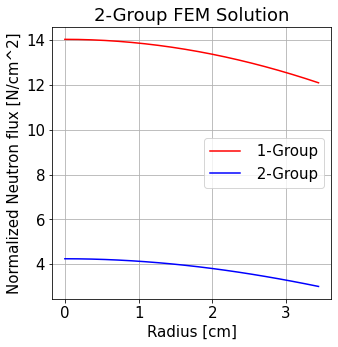

In [27]:
import pandas as pd
df = pd.read_csv('inputEigenProblem2g_reflector_out_x-data_0001.csv')
df2 = pd.read_csv('inputEigenProblem2g_reflector_out.csv')
#unormal=df2["u-normalized"]
#unormal2=df2["u-normalized2"]
fig = plt.figure(figsize=(5,5))


"""plt.plot(df["x"],df["u1"]/unormal[1],"r-",label=" 1-Group")
plt.plot(df["x"],df["u2"]/unormal2[1],"b-",label=" 2-Group")"""

plt.plot(df["x"],df["u1"],"r-",label=" 1-Group")
plt.plot(df["x"],df["u2"],"b-",label=" 2-Group")

#plt.yscale("log")
#plt.xlim(0,100)
plt.grid()
plt.legend()
plt.xlabel("Radius [cm]")
plt.ylabel("Normalized Neutron flux [N/cm^2]")
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.title("2-Group FEM Solution")

plt.show()

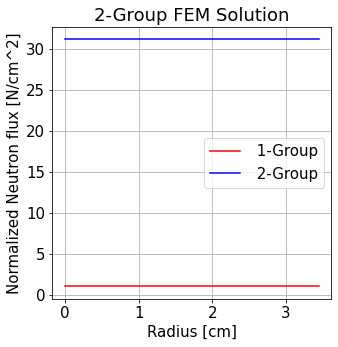

In [28]:
import pandas as pd
df = pd.read_csv('inputEigenProblem2g_reflector_out_x-data_0001.csv')
df2 = pd.read_csv('inputEigenProblem2g_reflector_out.csv')
unormal=df2["u-normalized"]
unormal2=df2["u-normalized2"]
fig = plt.figure(figsize=(5,5))

plt.plot(df["x"],df["u1"]/unormal[1],"r-",label=" 1-Group")
plt.plot(df["x"],df["u2"]/unormal[1],"b-",label=" 2-Group")
#plt.yscale("log")
#plt.xlim(0,100)
plt.grid()
plt.legend()
plt.xlabel("Radius [cm]")
plt.ylabel("Normalized Neutron flux [N/cm^2]")
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.title("2-Group FEM Solution")

plt.show()

#!rm output2G*.csv
#!./neutron__transport-opt -i input2G.hit

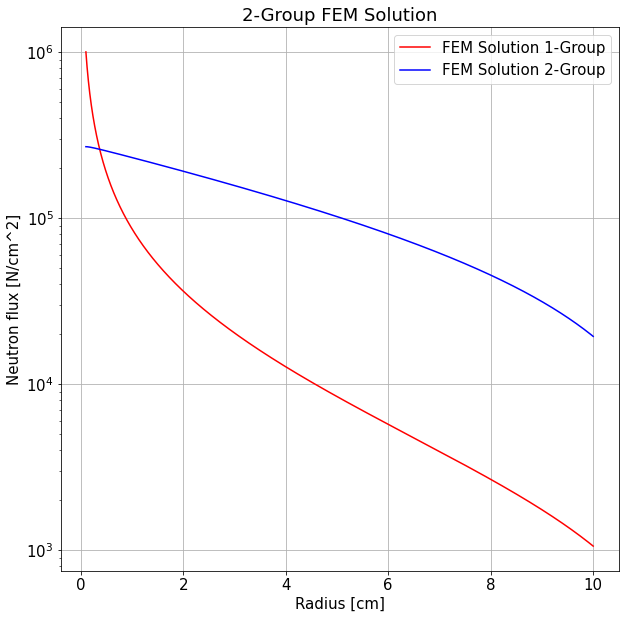

In [39]:
import pandas as pd
df = pd.read_csv('output2G_x-data_0002.csv')
fig = plt.figure(figsize=(10,10))
plt.plot(df["x"],df["u1"],"r-",label="FEM Solution 1-Group")
plt.plot(df["x"],df["u2"],"b-",label="FEM Solution 2-Group")
plt.yscale("log")
#plt.xlim(0,100)
plt.grid()
plt.legend()
plt.xlabel("Radius [cm]")
plt.ylabel("Neutron flux [N/cm^2]")
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.title("2-Group FEM Solution")
plt.show()

#!rm output2G*.csv
#!./neutron__transport-opt -i input2G.hit

## [FDM Approach](#toc)<a id="appFDM"></a>

### [Discretization](#toc)<a id="setupFDM"></a> 

For the discretization of the NDE a central approximation  is utilized, where for its respected differential 



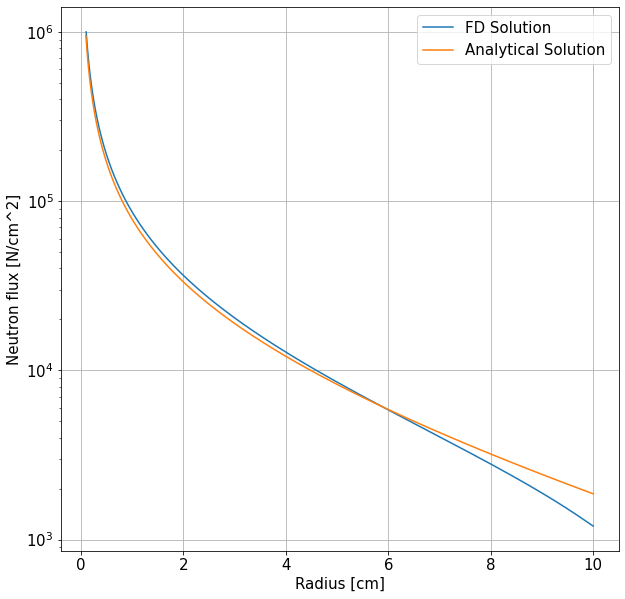

In [18]:
So = 1e6
N = 2000
rn = 10
r0 = 0.1
phi0 = So
alpha = 1

sigma_s = 0.022
D=0.87

h = (rn-r0)/(N+1)
r = np.arange(r0+h, rn, h)

A = np.zeros((N,N))
B = np.zeros(N)

A[0,0] = -sigma_s/D * h**2 - 2
A[0,1] = 1 + (h/(r0))
B[0] = -phi0 * (1-h/r0)

for i in range(1,N-1):
    A[i,i-1] = (1-(h/r[i]))
    A[i,i] = -sigma_s/D * h**2 - 2
    A[i,i+1] = 1 + (h/r[i])
    B[i] = 0

A[-1,-1] = (-h * alpha - 2 - h**2 * alpha/rn - sigma_s * h**2 / D)
A[-1,-2] = 1 + 1+h/rn-h/rn
B[-1] = 0

L = np.sqrt(D/sigma_s)

group1 = np.linalg.solve(A , B)
group1 = np.concatenate((np.array([phi0]),group1,np.array([group1[-1]])))

r = np.concatenate((np.array([r0]),r,np.array([rn])))


x = np.linspace(0.1-h,10,N)
y = So/(4*np.pi * x * D)*np.exp(-x/L)

fig = plt.figure(figsize=(10,10))
plt.plot(r,group1,label="FD Solution")
plt.plot(x,y,label="Analytical Solution")
plt.xlabel("Radius [cm]")
plt.ylabel("Neutron flux [N/cm^2]")
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.yscale("log")
plt.grid()
plt.legend()
plt.savefig("AnalyticalFDSolution.png",dpi=300)
plt.show()

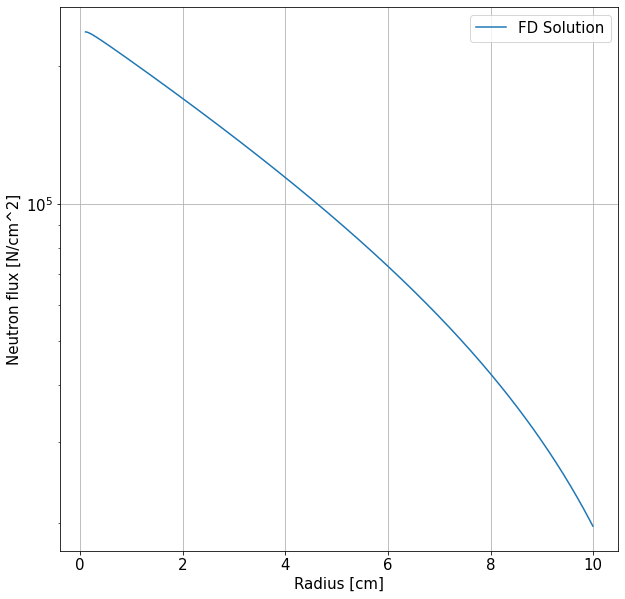

In [19]:
#Two group Finite Difference Method
So = 1e6
N = 2000
rn = 10
r0 = 0.1
phi0 = So
alpha = 1
sigma_1=0.022
sigma_2 = 0.022
sigma_12=0.87

D=0.87
L1 = np.sqrt(D/sigma_1)
h = (rn-r0)/(N+1)
r = np.arange(r0+h, rn, h)

A = np.zeros((N,N))
B = np.zeros(N)

A[0,0] = -sigma_2/D * h**2 - 2
A[0,1] = 2
B[0] = -sigma_12*h**2*group1[0]
#*So*np.exp(-r0/L1)/(4*np.pi*r0*D)

for i in range(1,N-1):
    A[i,i-1] = (1-(h/r[i]))
    A[i,i] = -sigma_2/D * h**2 - 2
    A[i,i+1] = 1 + (h/r[i])
    B[i] = -sigma_12*h**2*group1[i]
    #So*np.exp(-r[i]/L1)/(4*np.pi*r[i]*D)

A[-1,-1] = (-h * alpha - 2 - h**2 * alpha/rn - sigma_2 * h**2 / D)
A[-1,-2] = 1 + 1+h/rn-h/rn
B[-1] = -sigma_12*h**2*group1[-1]
#So*np.exp(-rn/L1)/(4*np.pi*rn*D)

L = np.sqrt(D/sigma_1)

group2 = np.linalg.solve(A , B)

#group2 = np.concatenate((np.array([phi0]),group2,np.array([group1[-1]])))
#r = np.concatenate((np.array([r0]),r,np.array([rn])))


x = np.linspace(0.1-h,10,N)
y = So/(4*np.pi * x * D)*np.exp(-x/L)

fig = plt.figure(figsize=(10,10))
plt.plot(r,group2,label="FD Solution")
#plt.plot(x,y,label="Analytical Solution")
plt.xlabel("Radius [cm]")
plt.ylabel("Neutron flux [N/cm^2]")
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.yscale("log")
plt.grid()
plt.legend()
plt.savefig("AnalyticalFDSolution.png",dpi=300)
plt.show()

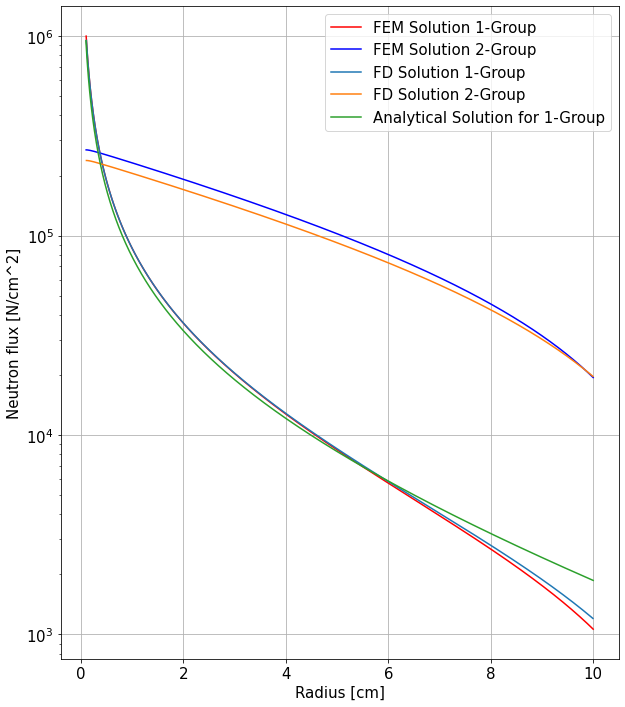

In [20]:
fig = plt.figure(figsize=(10,12))
plt.plot(df["x"],df["u1"],"r-",label="FEM Solution 1-Group")
plt.plot(df["x"],df["u2"],"b-",label="FEM Solution 2-Group")

plt.plot(r,group1[1:-1],label="FD Solution 1-Group")

#newely added
plt.plot(r,group2,label="FD Solution 2-Group")

plt.plot(x,y,label="Analytical Solution for 1-Group")
plt.yscale("log")
#plt.xlim(0,100)
plt.grid()
plt.legend()
plt.xlabel("Radius [cm]")
plt.ylabel("Neutron flux [N/cm^2]")
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)
plt.savefig("Analytical_FD_FEM_Sols.png",dpi=300)
plt.show()

## [Results and Analysis](#toc)<a id="ranalysis"></a>